<a href="https://colab.research.google.com/github/Claudio-Ferriz/c18-64-t-data-bi/blob/main/NO_COUNTRY_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##instalaciones
* falta conectar github con esta notebook

In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
#falta depurar librerias
import requests
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
import os
import glob
from unidecode import unidecode
import folium
from ipywidgets import interact, Dropdown
from geopy.geocoders import Nominatim
import re
import pandas as pd
import numpy as np
from folium.plugins import HeatMap
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns

## elección datos tablas delito y ventas

In [ ]:
filas_elegidas_delito = ['Hurto automotor', 'Robo automotor',"Robo total",'Homicidios dolosos', 'Amenazas', 'Lesiones Dolosas']

In [ ]:
data = pd.read_csv("/content/delitos_2016.csv")
data["subtipo"].unique()

array(['Robo total', 'Robo automotor', 'Hurto automotor', 'Hurto total',
       'Lesiones por siniestros viales', 'Homicidios dolosos',
       'Femicidios', 'Amenazas', 'Lesiones Dolosas',
       'Muertes por siniestros viales'], dtype=object)

In [ ]:
from itertools import combinations

elementos = ['Robo total', 'Robo automotor', 'Hurto automotor', 'Hurto total',
             'Lesiones por siniestros viales', 'Homicidios dolosos',
             'Femicidios', 'Amenazas', 'Lesiones Dolosas',
             'Muertes por siniestros viales']

# Generar todas las combinaciones únicas de tamaño 2 sin importar el orden
combinaciones_unicas = list(combinations(elementos, 6))

# Convertir las combinaciones en una lista de listas
lista_de_listas = [list(combinacion) for combinacion in combinaciones_unicas]

lista_de_listas

## Tabla delitos y tabla ventas
* si se recién se descarga los datos totales, el class del delito tarda máximo 1 minutos en cargar. Luego de eso dura max 5 segundos
* el código se va a modificar según las visualizaciones necesarias
* datos superficie por barrio https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2016/04/DT011123.pdf

In [ ]:
class DelitosAnual:
    def __init__(self, year):
        if not isinstance(year, int) or year < 2016 or year > 2022:
            raise ValueError("El año debe estar entre 2016 y 2022.")
        self.year = year

    def csv_raw(self,abrir=True): #iteración descargar todo, no continuar sino
        link = f'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_{self.year}.csv'
        ruta_archivo = f'/content/delitos_{self.year}.csv'
        if not os.path.exists(ruta_archivo):
          with open(ruta_archivo, 'wb') as file:
              file.write(requests.get(link).content)
        if abrir:
          return pd.read_csv(ruta_archivo)

    def tabla_general(self):
        csv = self.csv_raw()
        columnas_necesarias = ["mes",	"subtipo",	"barrio",	"latitud",	"longitud",	"cantidad"]
        filas_necesarias = filas_elegidas_delito
        csv =csv.dropna()
        csv_filas = csv[csv['subtipo'].isin(filas_necesarias)]
        csv_filas = csv_filas[~((csv_filas['uso_arma'] == 'NO') & (csv_filas['subtipo'] == 'Robo total'))]
        csv_colums = csv_filas[columnas_necesarias]
        tabla_general = csv_colums.rename(columns={'subtipo': 'delito'})
        tabla_general['delito'] = tabla_general['delito'].replace('Robo total', 'Robo Armado')

        return tabla_general

    def tabla_por_delito(self):
        csv = self.tabla_general()
        csv = csv.drop(["latitud", "longitud"], axis =1) ####
        meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
        trimestres = {1: f'{self.year}.1', 2: f'{self.year}.2', 3: f'{self.year}.3', 4: f'{self.year}.4'}
        mes_a_trimestre = {mes: trimestres[(i // 3) + 1] for i, mes in enumerate(meses)}
        csv['trimestre'] = csv['mes'].map(mes_a_trimestre)
        tabla_por_delito = csv.groupby(['trimestre', 'delito', 'barrio']).agg({'cantidad': 'sum'}).reset_index()
        tabla_por_delito = tabla_por_delito.pivot_table(index=["barrio","trimestre"],columns='delito', values='cantidad', fill_value=0).reset_index()
        tabla_por_delito.columns.name = None
        return tabla_por_delito

    def tabla_por_trimestre(self):
        csv = self.tabla_por_delito()
        columnas_int = csv.select_dtypes(include=['int'])
        suma_columnas_int = columnas_int.sum(axis=1)
        csv = csv.drop(columnas_int.columns, axis=1)
        csv['delito total'] = suma_columnas_int
        tabla_por_trimestre = csv.pivot(index="barrio",columns='trimestre', values='delito total').reset_index()
        tabla_por_trimestre.columns.name = None
        return tabla_por_trimestre

    def tabla_por_trimestre_sup(self, redondear=True):
        csv = self.tabla_por_trimestre()
        trimestres = csv.columns[-4:]
        csv[trimestres] = csv[trimestres].astype(float)
        barrios_superficie = [2.1, 4, 4.3, 7.9, 7.9, 5, 2.6, 6.8, 3.1, 1.2, 2.2, 2.1, 8.5, 2.3, 4.3, 7.3, 2.2, 2.6, 4.9, 4.3, 15.7, 4.7, 3.8, 1.3, 3.7, 2.2, 5, 6.1, 4.5, 5.5, 2, 2.2, 1.2, 2.4, 1.4, 3.6, 3.3, 6.4, 2.1,9.2, 2.5, 1.8, 3.3, 1.3, 4.2, 2.1, 8.6, 5.4]
        for i, row in csv.iterrows():
          csv.loc[i, trimestres] = row[trimestres] / barrios_superficie[i]
        if redondear:
          csv = csv.applymap(self.redondeo_numeros)
        return csv

    @staticmethod
    def redondeo_numeros(x):
      if isinstance(x, float):
        return round(x, 3)
      else:
        return x

    def descargar_todos_los_archivos(self):
        archivos_existentes = glob.glob('/content/delitos_*.csv')
        if len(archivos_existentes) < 7:
            for year in range(2016, 2023):
                self.year = year
                self.csv_raw(abrir=False)

    def combinar_todos_los_archivos(self, redondear=False):
        self.descargar_todos_los_archivos()
        year = 2016
        self.year = year
        tabla_primera = self.tabla_por_trimestre_sup(redondear=redondear)
        tabla_primera["barrio"] = tabla_primera["barrio"].str.title()
        tabla_primera["barrio"] =tabla_primera["barrio"].apply(unidecode)
        tabla_primera = tabla_primera.rename(columns={'barrio': 'Barrio'})
        all_data = [tabla_primera]
        for year in range(2017, 2023):
            self.year = year
            all_data.append(self.tabla_por_trimestre_sup(redondear=redondear).iloc[:, 1:])
        combined_data = pd.concat(all_data, axis=1)
        combined_data.set_index("Barrio", inplace=True)
        return combined_data

year_delito = DelitosAnual(2016)
csv_crudo = year_delito.csv_raw()
tabla_con_ubicaciones = year_delito.tabla_general()
tabla_por_delito = year_delito.tabla_por_delito()
tabla_por_trimestre = year_delito.tabla_por_trimestre()
tabla_por_trimestre_sup_redondeado = year_delito.tabla_por_trimestre_sup()
tabla_delitos = year_delito.combinar_todos_los_archivos()

In [ ]:
class ETLDeptoVentas:
    def __init__(self):
        self.tabla = self.xlsx_raw()

    def xlsx_raw(self):
        link = 'https://www.estadisticaciudad.gob.ar/eyc/wp-content/uploads/2023/12/MI_DVP_AX04.xlsx'
        ruta_archivo = '/content/MI_DVP_AX04.xlsx'
        if not os.path.exists(ruta_archivo):
            with open(ruta_archivo, 'wb') as file:
                file.write(requests.get(link).content)
        return pd.read_excel(ruta_archivo)

    def notas(self):
      for element in self.tabla.iloc[53:, 0]:
        print(element)

    def tabla_2016_2024(self, redondear=True):
      tabla_sin_NaN = self.tabla.dropna(thresh=len(self.tabla.columns)-4).replace({'///': 0})
      tabla_barrios = tabla_sin_NaN.drop(tabla_sin_NaN.columns[1], axis=1).drop(2)
      def transformacion_1():
        veces_repetidas = 0
        for columna in tabla_barrios.columns:
          if '1er. trim.' in tabla_barrios[columna].values:
            veces_repetidas += 1
            if veces_repetidas == 10:
              return tabla_barrios.columns.get_loc(columna)

      columnas_a_eliminar = tabla_barrios.columns[1:transformacion_1()]
      tabla_barrios = tabla_barrios.drop(columns=columnas_a_eliminar).drop(1)

      def transformacion_2():
        barrio = ['Barrio']
        current_year = 2016
        count_year = 0
        for i in range(1, len(tabla_barrios.columns)):
          if (i - 1) % 4 == 0 and i > 1:
            current_year += 1
            count_year = 0
          count_year += 1
          if count_year > 4:
            count_year = 1
          barrio.append(str(current_year) + '.' + str(count_year))
        return barrio

      tabla_barrios.columns = transformacion_2()
   #   barrios_informales = tabla_barrios[(tabla_barrios == 0.00).sum(axis=1) >= 22]
    #  tabla_barrios = tabla_barrios[~tabla_barrios["Barrio"].isin(barrios_informales.iloc[:, 0].unique())]
      tabla_barrios.reset_index(drop=True, inplace=True)
      tabla_barrios["Barrio"] =tabla_barrios["Barrio"].apply(unidecode)
      tabla_barrios["Barrio"] = tabla_barrios["Barrio"].str.title()
      tabla_barrios.iloc[tabla_barrios[tabla_barrios["Barrio"] == 'La Paternal'].index, tabla_barrios.columns.get_loc("Barrio")] = 'Paternal'
      tabla_barrios.iloc[tabla_barrios[tabla_barrios["Barrio"] == 'Montserrat'].index, tabla_barrios.columns.get_loc("Barrio")] = 'Monserrat'
      tabla_barrios = tabla_barrios.sort_values(by='Barrio')
      tabla_barrios.set_index("Barrio", inplace=True)

      if redondear:
        tabla_barrios = tabla_barrios.applymap(self.redondeo_numeros)
      return tabla_barrios

    @staticmethod
    def redondeo_numeros(x):
      if isinstance(x, float):
        return round(x, 3)
      else:
        return x
tabla_hasta_2024 = ETLDeptoVentas().tabla_2016_2024(redondear=False)
notas_tabla1 = ETLDeptoVentas().notas()
tabla_ventas = tabla_hasta_2024.iloc[:, :tabla_hasta_2024.columns.get_loc('2022.4')+1]

Nota: solo se muestran valores para los barrios que cumplen con la cantidad mínima de unidades ofertadas requerida en cada caso. 
Hasta 2014 inclusive la información corresponde al primer mes del trimestre.
Los datos presentados pueden diferir de los publicados anteriormente debido a la implementación de cambios metodológicos en el cálculo del precio por metro cuadrado.
La información anterior a 2010 se encuentra en revisión.
Fuente: Dirección General de Estadística y Censos (Ministerio de Hacienda y Finanzas GCBA) sobre la base de datos del sistema Buscainmueble (hasta julio 2011), Adinco (entre octubre 2011 y abril 2015) y Argenprop (desde julio 2015).


## descargar tablas

In [ ]:
#descargar archivo en carpeta google colab
if os.path.exists('/content/tabla_delitos.csv'):
    os.remove('/content/tabla_delitos.csv')
tabla_delitos.to_csv('/content/tabla_delitos.csv', index=True)

In [ ]:
#descargar archivo en carpeta google colab
if os.path.exists('/content/tabla_venta.csv'):
    os.remove('/content/tabla_venta.csv')
tabla_ventas.to_csv('/content/tabla_venta.csv', index=True)

## mapas
falta trabajar con la libreria pyinkscape para tener los dos mapas interactivos con colores. Por ahora se tiene el código para el mapa interactivo de ubicaciones


In [ ]:
class Delitos_Mapa_puntos:
    def __init__(self):
        self.years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
        self.trimestres = ["primer trimestre", "segundo trimestre", "tercer trimestre", "cuarto trimestre"]
        self.comunas = [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.,13.,14.,15., "Todas"]
        self.delitos = filas_elegidas_delito + ['Todos']
        self.colores_delitos = {
            'Hurto automotor': 'blue',
            'Robo automotor': 'green',
            'Robo Armado': 'red',
            'Homicidios dolosos': 'black',
            'Amenazas': 'orange',
            'Lesiones Dolosas': 'purple'
        }
        self.geolocator = Nominatim(user_agent="myGeocoder")
    def descargar_todos_los_archivos(self):
        archivos_existentes = glob.glob('delitos_*.csv')
        if len(archivos_existentes) < 7:
            for year in range(2016, 2023):
              ruta_archivo = f'delitos_{year}.csv'
              if not os.path.exists(ruta_archivo):
                with open(ruta_archivo, 'wb') as file:
                    link = f'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-justicia-y-seguridad/delitos/delitos_{year}.csv'
                    file.write(requests.get(link).content)

    def ver_archivo(self, year):
        ruta_archivo = f'delitos_{year}.csv'
        return pd.read_csv(ruta_archivo)

    def tabla_delito_ubicacion(self, year):
        csv = self.ver_archivo(year)
        columnas_necesarias = ["subtipo", "mes", "comuna", "latitud", "longitud"]
        filas_necesarias = ['Hurto automotor', 'Robo automotor', 'Robo total', 'Homicidios dolosos', 'Amenazas', 'Lesiones Dolosas']
        csv = csv.dropna()
        csv = csv[csv['subtipo'].isin(filas_necesarias)]
        csv = csv[~((csv['uso_arma'] == 'NO') & (csv['subtipo'] == 'Robo total'))]
        csv = csv[columnas_necesarias]
        tabla = csv.rename(columns={'subtipo': 'delito'})
        tabla['delito'] = tabla['delito'].replace('Robo total', 'Robo Armado')
        meses = ['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']
        tabla['mes'] = pd.Categorical(tabla['mes'], categories=meses, ordered=True)
        tabla = tabla.sort_values(by='mes')
        tabla.reset_index(drop=True, inplace=True)
        trimestres = {1: "primer trimestre", 2: "segundo trimestre", 3: "tercer trimestre", 4: "cuarto trimestre"}
        mes_a_trimestre = {mes: trimestres[(i // 3) + 1] for i, mes in enumerate(meses)}
        tabla['trimestre'] = tabla['mes'].map(mes_a_trimestre)
        tabla = tabla.drop(columns=['mes'])
        tabla = tabla.sort_values(by='comuna', ascending=True)
        return tabla

    def generar_mapa_interactivo(self):
        @interact(year=Dropdown(options=self.years, description="Año"),
                  trimestre=Dropdown(options=self.trimestres, description="Trimestre"),
                  delito=Dropdown(options=self.delitos, description="Tipo de Delito", value='Todos'),
                  comuna=Dropdown(options=self.comunas, description="Comuna", value='Todas'))
        def mostrar_mapa(year, trimestre, delito, comuna):
            tabla_delitos = self.tabla_delito_ubicacion(year)
            tabla_delitos = tabla_delitos[tabla_delitos['trimestre'] == trimestre]
            if comuna != 'Todas':
                tabla_delitos = tabla_delitos[tabla_delitos['comuna'] == comuna]

            mapa = folium.Map(location=[-34.61, -58.44], zoom_start=12)

            if delito == 'Todos':
                for tipo_delito, color in self.colores_delitos.items():
                    delitos_tipo = tabla_delitos[tabla_delitos['delito'] == tipo_delito]
                    self.agregar_marcadores(mapa, delitos_tipo, color)
            else:
                delitos_tipo = tabla_delitos[tabla_delitos['delito'] == delito]
                color = self.colores_delitos[delito]
                self.agregar_marcadores(mapa, delitos_tipo, color)

            display(mapa)

    def agregar_marcadores(self, mapa, datos, color):
        for index, row in datos.iterrows():
            folium.CircleMarker(location=[row['latitud'], row['longitud']], radius=1, color=color, fill=True, fill_color=color).add_to(mapa)

Delitos_Mapa_puntos().generar_mapa_interactivo()
#columna a int

interactive(children=(Dropdown(description='Año', options=(2016, 2017, 2018, 2019, 2020, 2021, 2022), value=20…

## normalización y correlación

In [ ]:
tabla_delitos.shape[0]

48

In [ ]:
def escalar_valores(tabla):
    # Función para escalar los valores de cada columna
    def escalar_columna(col):
        non_zero_mask = col != 0
        non_zero_values = col[non_zero_mask]
        if len(non_zero_values) > 1:
            scaled_values = (non_zero_values.rank(method='min') - 1) / (len(non_zero_values) - 1) * 47 + 1
            col[non_zero_mask] = scaled_values.round(4)  # Redondear a dos cifras significativas
        col[non_zero_mask] = col[non_zero_mask].astype(float)
        col[~non_zero_mask] = 0
        return col

    # Aplicar la función a cada columna
    tabla_escalada = tabla.apply(escalar_columna)
    return tabla_escalada

# Aplicar la transformación a la tabla
tabla_transformada = transformar_tabla(tabla_delitos)

# Mostrar la tabla transformada
tabla_transformada


2016.1  2016.2  2016.3  2016.4  2017.1  2017.2  2017.3  \
Barrio                                                                      
Agronomia               5       7       3      18       3       3       3   
Almagro                37      44      34      27      38      41      42   
Balvanera              45      48      45      46      45      47      47   
Barracas               40      18      19      12      33      35      34   
Belgrano               14      19      36       5       8       8      12   
Boca                   41      20      16      20      32      34      35   
Boedo                  30      41      20      15      34      36      36   
Caballito              33      38      33      14      28      28      32   
Chacarita              24      27      35      16      26      23      25   
Coghlan                 9       5      18      13      22      16       9   
Colegiales             17      29      37       9      21      21      17   
Constitucion           48      43      48      48      48      48      48   
Flores                 36      36      47      28      39      40      37   
Floresta               26      25      27      41      31      38      30   
Liniers                34      28      28      43      24      25      26   
Mataderos              20      13      10      32      12      17      15   
Monserrat              47      42      44      45      42      44      44   
Monte Castro            2       3       2      23      11      18       8   
Nueva Pompeya          29      30      14      11      20      27      29   
Nunez                   4       9      30       4       5       9       6   
Palermo                22      32      13       8      18      22      22   
Parque Avellaneda      23      15      32      25      27      31      27   
Parque Chacabuco       27      37      24       7      15      24      24   
Parque Chas            11       8      25      21      10       5      23   
Parque Patricios       38      33      22      19      35      30      40   
Paternal               28      23      39      14      21      20      19   
Puerto Madero           1       1       1       1       1       1       1   
Recoleta               39      31      26      22      36      39      38   
Retiro                 42      34      31      31      41      42      41   
Saavedra                6      11       8      10      16      12      16   
San Cristobal          44      45      42      40      44      45      46   
San Nicolas            46      40      43      44      43      46      45   
San Telmo              43      35      41      42      40      43      43   
Velez Sarsfield        12      22       5      38      23      29      18   
Versalles              13      16      12      33      13       7       4   
Villa Crespo           35      39      38      26      37      37      31   
Villa Del Parque       21      14      15      34       7      10      13   
Villa Devoto            7       6       6      29      19       4      10   
Villa Gral. Mitre      25      21      46      17      25      32      33   
Villa Lugano           32      26      40      36      30      33      39   
Villa Luro             18      12       7      35      29      13      20   
Villa Ortuzar          15      10      29       3      13      11       7   
Villa Pueyrredon        8       4       4      24       4      14      11   
Villa Real             31      17      21      39       6      19      14   
Villa Riachuelo         3       2      11       2       2       2       2   
Villa Santa Rita       19      10      23      37      17      26      28   
Villa Soldati          10      24      17       6       9       6       5   
Villa Urquiza          16      10       9      30      14      15      21   

                   2017.4  2018.1  2018.2  ...  2020.3  2020.4  2021.1  \
Barrio                                     ...                           
Agronomia           

In [ ]:
print(tabla_delitos.columns.tolist() == tabla_ventas.columns.tolist())

def borrar_indices_no_coincidentes(tabla1, tabla2):
    if any(idx not in tabla2.index for idx in tabla1.index) or any(idx not in tabla1.index for idx in tabla2.index):
        indices_comunes = tabla1.index.intersection(tabla2.index)
        tabla1_filtrada = tabla1.loc[indices_comunes]
        tabla2_filtrada = tabla2.loc[indices_comunes]
        return tabla1_filtrada, tabla2_filtrada
    else:
        print("Los índices coinciden entre ambas tablas.")
        return tabla1, tabla2
tabla_delitos, tabla_ventas = borrar_indices_no_coincidentes(tabla_delitos, tabla_ventas)

True
Los índices coinciden entre ambas tablas.


In [ ]:
def visualizar_correlacion(tabla1, tabla2):
    # Calcular la correlación global
    valores_tabla1 = tabla1.values.flatten()
    valores_tabla2 = tabla2.values.flatten()
    correlacion_global = pd.Series(valores_tabla1).corr(pd.Series(valores_tabla2))
    print(f'Correlación global: {correlacion_global}')

    # Graficar la correlación global en un gráfico de dispersión
    plt.figure(figsize=(8, 6))
    plt.scatter(valores_tabla1, valores_tabla2, alpha=0.5)
    plt.xlabel('Valores de delitos')
    plt.ylabel('Valores de ventas')
    plt.title(f'Correlación global: {correlacion_global:.2f}')
    plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def visualizar_correlacion_serie_temporal(tabla_delitos, tabla_ventas):
    # Calcular la media de los datos de todos los barrios
    delitos_media = tabla_delitos.mean(axis=0)
    ventas_media = tabla_ventas.mean(axis=0)

    # Crear una instancia del MinMaxScaler
    scaler = MinMaxScaler()

    # Normalizar los datos de la media de ambos conjuntos de datos
    delitos_media_norm = scaler.fit_transform(delitos_media.values.reshape(-1, 1)).flatten()
    ventas_media_norm = scaler.fit_transform(ventas_media.values.reshape(-1, 1)).flatten()

    # Crear la figura y los ejes
    plt.figure(figsize=(12, 6))

    # Graficar las series de tiempo normalizadas de los delitos y las ventas
    sns.lineplot(x=tabla_delitos.columns, y=delitos_media_norm, color='blue', label='Delitos por km2')
    sns.lineplot(x=tabla_ventas.columns, y=ventas_media_norm, color='red', label='Precios de inmuebles promedio')

    # Personalizar el gráfico
    plt.xlabel('Trimestre')
    plt.ylabel('Valor Normalizado')
    plt.title('Serie de tiempo promedio de delitos por km2 y precios de inmuebles promedio')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()


## visualización correlación para ir ajustando datos
* Falta debatir, para aumentar la correlación:
  * si borrar barrios informales como Villa Riachuelo
  * elegir que delitos van o no

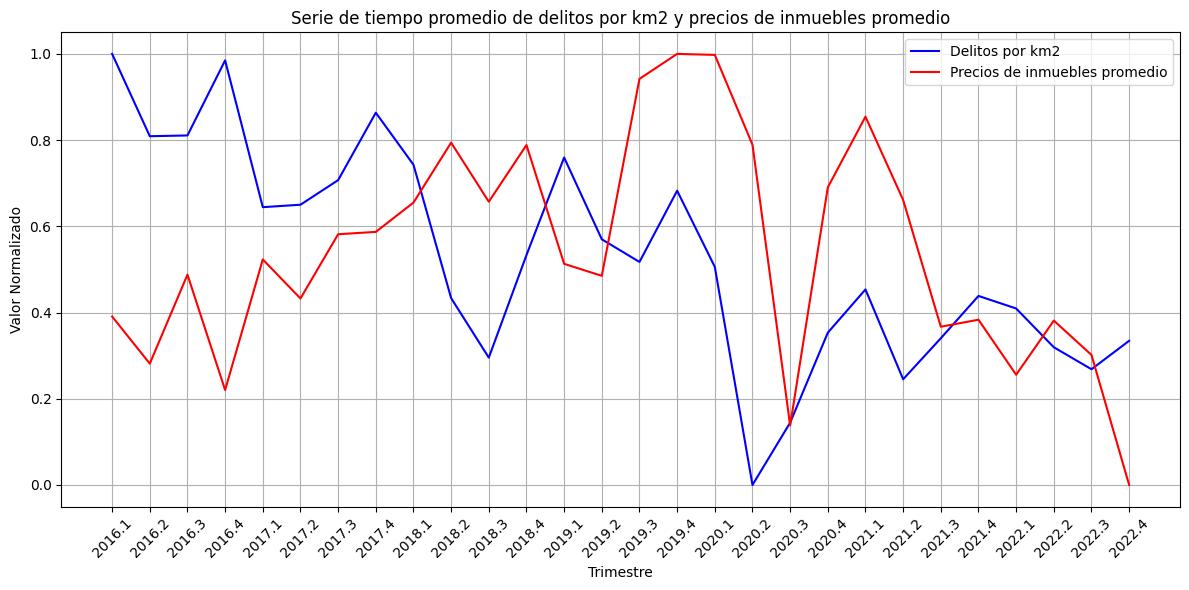

In [ ]:
filas_elegidas_delito = lista_de_listas[13]
visualizar_correlacion_serie_temporal(tabla_delitos, tabla_ventas)
#opción boton por barrio, no mencionar delitos elegidos

Correlación global: -0.05189316044819115


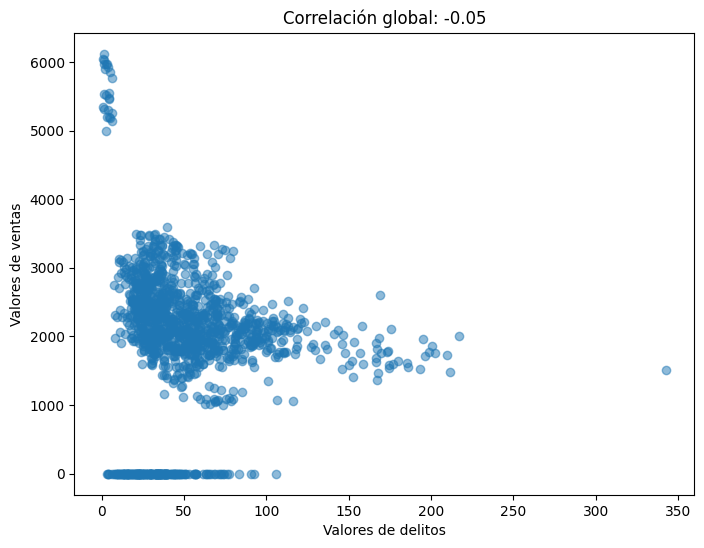

In [ ]:
visualizar_correlacion(tabla_delitos, tabla_ventas)

## Regresión lineal

In [ ]:
#mejor modelo
# 2016 a 2022, haga una predicción para 2023 y 2024 de ambas tablas. Y el output deseado debe ser cercano a los datos actuales de 2023 y 2024 de ventas